<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png"
         width="500" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>
            Chair of Soil Mechanics and Foundation Engineering<br>
            Geotechnical Institute<br>
            Technische Universität Bergakademie Freiberg.
        </p>
        <p>
            <a href="https://tu-freiberg.de/en/soilmechanics">
                https://tu-freiberg.de/en/soilmechanics
            </a>
        </p>
    </div>
</div>

<div style="display: flex; align-items: center;">
    <p style="margin-top: 1em;">
        To activate the <strong>interactive features</strong> when in nbviewer mode, click on &quot;Execute on Binder&quot;
        <img src="https://mybinder.org/static/favicon.ico"
             alt="Binder"
             style="height: 1.1em; vertical-align: middle; margin: 0 6px;">
        on the top right. Then, click on Run → Run All Cells.
    </p>
</div>


# Implicit functions

Before introducing gradients, let's refresh some concepts on implicit functions. The implicit function theorem is, among others, also used for computing algorithmically consistent tangent operators of material models implemented in implicit time-integration simulators.

Consider an implicit function $f(x_i) = 0$. To render things specific, let's choose

$$
    f(x,y) = \left( \frac{x}{a} \right)^2 + \left( \frac{y}{b} \right)^2 - c
$$

as ellipsoidal levelsets.

We plot the function for $a=1.2$, $b=0.5$ and $c \in \{-0.5,-0.2,0,0.2,0.5\}$ and observe concentric ellipses.

In [1]:
import numpy as np #numerical methods

#Some plot settings
#import plot_functions.plot_settings
%run plot_functions/plot_settings.py
%run plot_functions/iteration_schemes_plots.ipynb

from matplotlib import cm

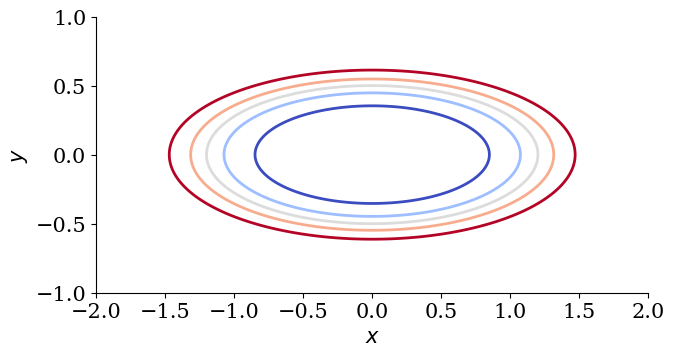

In [2]:
p = lambda x,y: -1 + (x/1.2)**2 + (y/0.5)**2

fig, ax = plt.subplots(figsize=(7,7))
#ax = fig.gca(projection='3d')
A = np.linspace(-2, 2, 1000) # resolution of the contour
X,Y = np.meshgrid(A,A)
cset = ax.contour(X, Y, p(X,Y), levels = [-0.5,-0.2,0,0.2,0.5], cmap=cm.coolwarm)

ax.set_xlabel(r'$x$')
ax.set_xlim(-2, 2)
ax.set_ylabel(r'$y$')
ax.set_ylim(-1, 1)
#ax.legend()
ax.set_aspect('equal')
fig.tight_layout()

Now we pick the zero-levelset, $c=0$, and wish to compute the derivative $\text{d}y/\text{d}x$ on that levelset. In other words, we want to know how far we have to progress in the $y$-direction given an infinitesimal step in $x$ direction, such that we stay on the levelset. The latter constraint leads to $\text{d}f = 0$ which can be expanded via the total differential

\begin{align}
    \text{d}f = 0 &= \frac{\partial f}{\partial x} \text{d}x + \frac{\partial f}{\partial y} \text{d}y
    \\
    &= 2\frac{x}{a^2} \text{d}x + 2\frac{y}{b^2} \text{d}y
\end{align}

Rearrangement yields the answer to the question posed above:

$$
    \text{d}y = - \frac{b^2}{a^2} \frac{x}{y} \text{d}x
$$

or alternatively

$$
    \frac{\text{d}y}{\text{d}x} = - \frac{b^2}{a^2} \frac{x}{y}
$$

Let's plot a couple of vectors $(\text{d}x,\text{d}y)^\text{T}$ for $\text{d}x = \pm 0.1$ at different values of $x \in [-1.15,1.15]$ and see where we land:

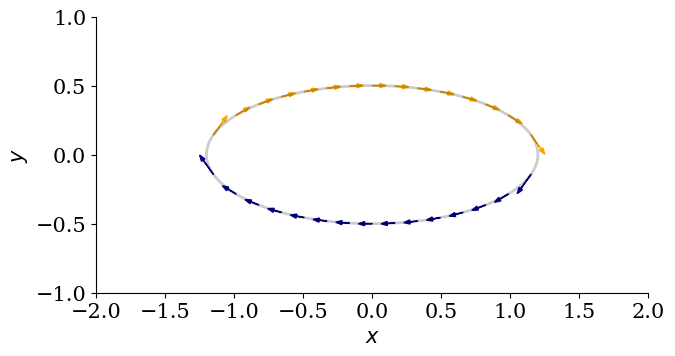

In [3]:
p = lambda x,y: -1 + (x/1.2)**2 + (y/0.5)**2

dy_dx = lambda x,y: -(0.5/1.2)**2 * x/y

y_p = lambda x: np.sqrt((1 - (x/1.2)**2)*0.25)
y_n = lambda x: -np.sqrt((1 - (x/1.2)**2)*0.25)

fig, ax = plt.subplots(figsize=(7,7))
A = np.linspace(-2, 2, 1000) # resolution of the contour
X,Y = np.meshgrid(A,A)
cset = ax.contour(X, Y, p(X,Y), levels = [0], colors=['black'],alpha = 0.2)

xs = np.linspace(-1.15,1.15,15)

for x in xs:
    ax.arrow(x,y_p(x),0.1,dy_dx(x,y_p(x))*0.1,color='orange',length_includes_head='true',head_width=0.03)
    ax.arrow(x,y_n(x),-0.1,dy_dx(x,y_n(x))*-0.1,color='darkblue',length_includes_head='true',head_width=0.03)

ax.set_xlabel(r'$x$')
ax.set_xlim(-2, 2)
ax.set_ylabel(r'$y$')
ax.set_ylim(-1, 1)
#ax.legend()
ax.set_aspect('equal')
fig.tight_layout()

In areas with large curvature, the error made by linearization becomes visible. For infinitesimal steps, we obtain a differential description of the ellipsoid.

### Example: computation of consistent tangent

DAE system to calculate stress increment at each global iteration $i$:

$$
	\boldsymbol{0} = \boldsymbol{r}(\boldsymbol{z},\boldsymbol{\epsilon}^i) \quad \text{with} \quad \boldsymbol{z} = (\boldsymbol{\sigma}^\text{T}, \boldsymbol{\kappa}^\text{T}_k, \kappa_k)^\text{T} 
$$

where the state variables (or their increments) are also driven by strain, i.e. $\boldsymbol{z}(\boldsymbol{\epsilon}^i)$. Note in passing, that we actually drive the system by an *incremental* strain $\Delta \boldsymbol{\epsilon}^i$ and could also reflect this in the notation.

Linearisation, local iteration counter $j$:

$$
	-\boldsymbol{r}^j = \left. \frac{\partial \boldsymbol{r}}{\partial \boldsymbol{z}} \right|_j \Delta \boldsymbol{z}^{j+1} 
$$

Once converged, stresses and internal variables are updated for the next global iteration. Furthermore, we use the implicit function theorem

$$
	\frac{\text{d} \boldsymbol{r}}{\text{d} \boldsymbol{\epsilon}} = \frac{\partial \boldsymbol{r}}{\partial \boldsymbol{\epsilon}} + \left( \left. \frac{\partial \boldsymbol{r}}{\partial \boldsymbol{z}} \right|_{t+\Delta t} \right) \frac{\text{d} \boldsymbol{z}}{\text{d} \boldsymbol{\epsilon}} = \boldsymbol{0} 
$$

and solve

$$
	 \left( \left. \frac{\partial \boldsymbol{r}}{\partial \boldsymbol{z}} \right|_{t+\Delta t} \right) \frac{\text{d} \boldsymbol{z}}{\text{d} \boldsymbol{\epsilon}} = -\frac{\partial \boldsymbol{r}}{\partial \boldsymbol{\epsilon}} 
$$

The first entry of the solution $\text{d} \boldsymbol{z} / \text{d} \boldsymbol{\epsilon}$ is the algorithmically consistent tangent matrix ${}^{t+\Delta t}\boldsymbol{C}^{i}$. It corresponds to whatever pair of stress and strain measures is used to drive the system.

# Constrained minimization, Lagrange multipliers

These are some thoughts to help introduce the notion of Lagrange multipliers in optimization problems. We want to understand (among many other things)

* why we can simply add constraints multiplied by Lagrange multipliers to objective functions to find constrained extrema,
* how Lagrange multipliers are related to the Lagrangian formalism in mechanics,
* why they are often interpreted as (generalized, thermodynamic) reaction forces to constraints.

## Intuitive (geometric) motivation

Consider the function $f(x,y)$ which we wish to minimize by finding $\nabla f = \mathbf{0}$. At the same time we want to fulfill some constraint $g(x,y) = 0$. This could be related to finding equlibrium conditions in multiphase materials constrained to remain fully saturated.

To be more specific, we choose the functions

\begin{align}
    f(x,y) &= 1 + 0.8 x^2 + 0.3 y^2
    \\
    g(x,y) &= (2 + 0.6x) - f(x,y)
\end{align}

here. In other words, the optimal state shall lie on the plane $\tilde{g}(x,y) = 2 + 0.6x$.

In [4]:
p = lambda x,y: 1.+0.8*x**2 + 0.3*y**2
g = lambda x: 0.6*x +2

Let's plot them in 3D along with some isolines projected onto the $x-y$ plane.

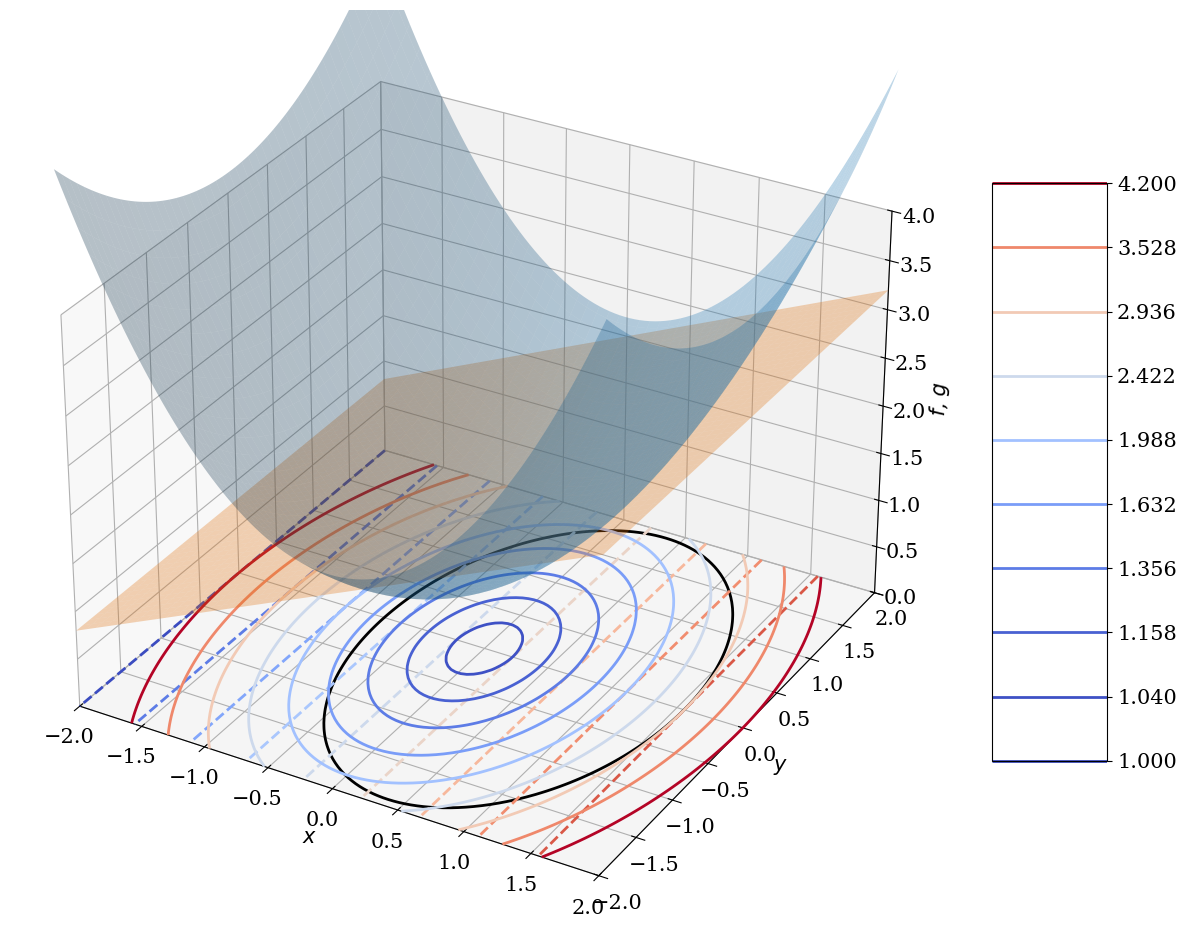

In [5]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection='3d')
A = np.linspace(-2, 2, 100) # resolution of the contour
X,Y = np.meshgrid(A,A)
surf = ax.plot_surface(X, Y, p(X,Y), alpha=0.3)
constr = ax.plot_surface(X, Y, g(X), alpha=0.3)
ax.set_xlabel(r'$x$')
ax.set_xlim(-2, 2)
ax.set_ylabel(r'$y$')
ax.set_ylim(-2, 2)
ax.set_zlabel(r'$f$, $g$')
ax.set_zlim(0, 4)
fig.tight_layout()
cset = ax.contour(X, Y, p(X,Y), zdir='z', levels = p(np.linspace(0, 2, 10),0), offset=0, cmap=cm.coolwarm)
cset2 = ax.contour(X, Y, g(X), zdir='z', levels = g(np.linspace(-2, 2, 10)), offset=0, cmap=cm.coolwarm,linestyles='dashed')
cset3 = ax.contour(X, Y, p(X,Y)-g(X), levels = [0],colors = ['black'])
fig.colorbar(cset, shrink=0.5, aspect=5)
#fig.tight_layout();

The black line shows the intersecting curve between both surfaces.

To understand a little bit better what's going on, let's draw gradients with the isolines. Remember, that gradients indicate the direction of steepest ascent. We want to walk into the valley, i.e. opposite to the gradient vectors.

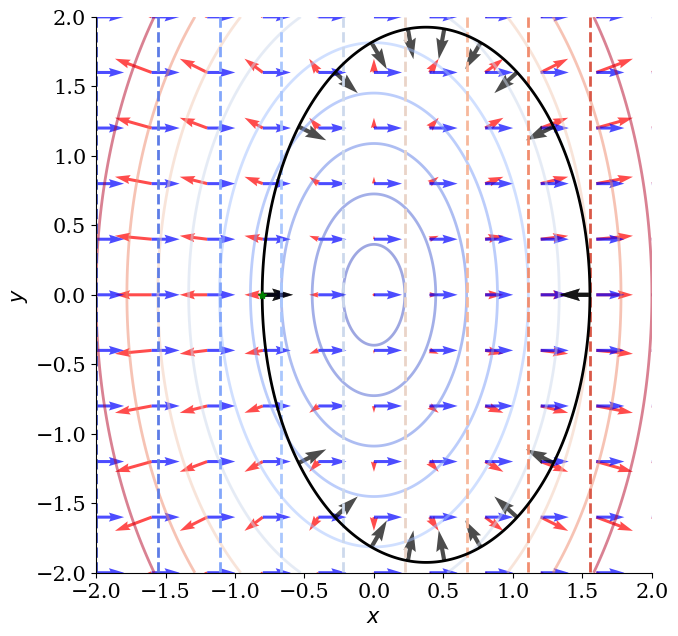

In [6]:
p = lambda x,y: 1.+0.8*x**2 + 0.3*y**2
g = lambda x: 0.6*x +2
c = lambda x,y: g(x) - p(x,y)


fig, ax = plt.subplots(figsize=(7,7))
#ax = fig.gca(projection='3d')
A = np.linspace(-2, 2, 1000) # resolution of the contour
X,Y = np.meshgrid(A,A)
cset = ax.contour(X, Y, p(X,Y), levels = p(np.linspace(0, 2, 10),0), cmap=cm.coolwarm,alpha=0.5)
cset = ax.contour(X, Y, g(X), levels = g(np.linspace(-2, 2, 10)), linestyles='dashed', cmap=cm.coolwarm)
cset = ax.contour(X, Y, c(X,Y), levels = [0],colors = ['black'])
B = np.linspace(-2, 2, 11) 
Xv,Yv = np.meshgrid(B,B)


grad_p_x = 1.6*Xv
grad_p_y = 0.6*Yv

grad_g_x = 0.6
grad_g_y = 0

vec = ax.quiver(Xv, Yv, grad_p_x, grad_p_y, pivot='tail', alpha=0.7, ls='-', lw=2,color='red')
vec2 = ax.quiver(Xv, Yv, grad_g_x, grad_g_y, pivot='tail', alpha=0.7, ls='-', lw=2,color='blue')

y_constr = lambda x: np.sqrt((1+0.6*x-0.8*x**2)/0.3)
grad_c_x = lambda x: 0.6 - 1.6*x
grad_c_y = lambda y: 0 - 0.6*y

x_min = (3-np.sqrt(89))/8
x_max = (3+np.sqrt(89))/8
for x_constr in np.linspace(x_min,x_max,10):
    vec3 = ax.quiver(x_constr, y_constr(x_constr), grad_c_x(x_constr), grad_c_y(y_constr(x_constr)), 
                     pivot='tail', alpha=0.7, ls='-', lw=2,color='black')
    vec3 = ax.quiver(x_constr, -y_constr(x_constr), grad_c_x(x_constr), grad_c_y(-y_constr(x_constr)), 
                     pivot='tail', alpha=0.7, ls='-', lw=2,color='black')

ax.plot(x_min,y_constr(x_min),marker='*',color='green')
ax.set_xlabel(r'$x$')
ax.set_xlim(-2, 2)
ax.set_ylabel(r'$y$')
ax.set_ylim(-2, 2)
#ax.legend()
ax.set_aspect('equal')
fig.tight_layout()

fig.savefig('constrained_minimum_grad.pdf')

The red arrows represent $\nabla f$, the blue arrows $\nabla \tilde{g}$ and the black arrows $\nabla g$. From this picture, we can now read two conditions for the minimizer $(x^*,y^*)$ of $f$ subject to $g = 0$. Firstly

$$
    g(x^*,y^*) = 0
$$

needs to hold, i.e. we need to be on the black curve. Secondly, for our minimum we find that the gradient vectors are parallel but opposite (aligned for a maximum), i.e.:

$$
    \nabla f |_{x^*,y^*} = - \lambda \nabla g |_{x^*,y^*}
$$

In other words, the vectors pointing "downhill", $-\nabla f$, and the gradient of the constraint, $\nabla g$, are parallel and differ only by a scalar multiplier $\lambda$. If both vectors were not parallel, then there would be a component of the cost function gradient tangential to the constraint. In other words, one could "move" along the constraint and decrease or increase the value of the function. Therefore, as long as they are not aligned, one is not at an extremum.

All conditions can be satisfied by defining a functional $L(x,y,\lambda) = f(x,y) + \lambda g(x,y)$ for which we seek the optimum:

$$
    \text{grad} L = \mathbf{0} = 
    \begin{pmatrix}
        \frac{\partial L}{\partial x} 
        \\
        \frac{\partial L}{\partial y} 
        \\
        \frac{\partial L}{\partial \lambda} 
    \end{pmatrix}
    = 
    \begin{pmatrix}
        \frac{\partial f}{\partial x} + \lambda \frac{\partial g}{\partial x}
        \\
        \frac{\partial f}{\partial y} + \lambda \frac{\partial g}{\partial y}
        \\
        g(x,y)
    \end{pmatrix}
$$

Thus we see, why and how a function can be minimized in light of certain constraints.

For our case:
$$
    \text{grad} L = \mathbf{0} = 
    \begin{pmatrix}
        1.6x - \lambda (0.6 - 1.6x)
        \\
        0.6y
        \\
        1+0.6x - 0.8x^2 - 0.3y^2
    \end{pmatrix}
$$

Thus the sought minimum is $(x^*,y^*,\lambda^*) = \left[\frac{3-\sqrt{89}}{8},0,1-\frac{3}{\sqrt{89}}\right]$.

## Lagrange formalism with a physical example

Now let's connect this to the Lagrangian formalism known from mechanics.

### Introduction

The Lagrangian function (also see Noether's theorem or the stationary action principle) is defined as

$$
	L \equiv E_\text{kin} - E_\text{pot}
$$

and the Euler-Lagrange equation as

$$
	\frac{\text{d}}{\text{d}t}\frac{\partial L}{\partial \dot{\mathbf{x}}} = \frac{\partial L}{\partial \mathbf{x}}
$$

Consider a particle with constant mass moving in the potential $V(\mathbf{x})$, then applying the usual formalism to the Lagrangian

$$
	L = \frac{m}{2} \dot{\mathbf{x}} \cdot \dot{\mathbf{x}} - V(\mathbf{x})
$$

yields

$$
	\frac{\text{d}m \dot{\mathbf{x}}}{\text{d}t} = - \text{grad}\,V \quad \mbox{or} \quad \dot{\mathbf{p}} = m \ddot{\mathbf{x}} = \mathbf{F}
$$

i.e. the Euler-Lagrange equation recovers Newton's law.


### Constraints

We now proceed from a vector of generalized coordinates $\mathbf{q}$. For every constraint $\mathbf{c}(\mathbf{q}) = 0$ a (steep) force potential can be added that allows the calculation of a reaction force:
$$
	L_\text{c} = E_\text{kin} - E_\text{pot} - V_\text{c} = L - V_\text{c}(\mathbf{c})
	\quad \mbox{so that} \quad
	\frac{\text{d}}{\text{d}t} \frac{\partial L}{\partial \dot{\mathbf{q}}} = \frac{\partial L}{\partial \mathbf{q}} - \frac{\partial V_\text{c}}{\partial \mathbf{c}} \frac{\partial \mathbf{c}}{\partial \mathbf{q}} = \frac{\partial L}{\partial \mathbf{q}} + \mathbf{F}_c \frac{\partial \mathbf{c}}{\partial \mathbf{q}}
$$
Note, that the constraint (direction, magnitude) must be defined carefully to yield the desired reaction force. One also sees, that the reaction force has the role of a Lagrange multiplier.

Note: Non-conservative forces (like friction) can only be added manually once the equations of motion have been derived from the Lagrangian (using the $F=ma$ analogy).

Hence, one can write in a general sense

$$
	\frac{\text{d}}{\text{d}t} \frac{\partial L}{\partial \dot{\mathbf{q}}} - \frac{\partial L}{\partial \mathbf{q}} + \frac{\partial V_\text{c}}{\partial \mathbf{q}} = \mathbf{f}_\text{nc}
$$


<img src="https://github.com/nagelt/Numerical_Methods_Introduction/raw/master/Images/spring_slide.png" style="width: 300px;"/>

As an **example** consider the spring-pendulum-in-a-slide system as shown the figure. Sliding is frictionless, the spring is force-free at extension $l$. The coordinates $x$ and $y$ locate the point mass $m$.

**Option 1**: Seeing that the system has one DOF, one can directly write:

$$
	L = \frac{m}{2} \dot{y}^2 - \frac{k}{2}\left[ \sqrt{l^2 + y^2} - l \right]^2
$$

arriving at the EOM

$$
	m \ddot{y} + k y \frac{\sqrt{1 + \left( \frac{y}{l} \right)^2} - 1}{\sqrt{1 + \left( \frac{y}{l} \right)^2}} = 0
$$

In order to find the reaction force of the constraint, one may also follow **option 2**. Consider the system as having 2 DOFs and being subject to the constraint

$$
    c = x - l = 0
$$

The Lagrangian is then found as

$$
	L = \frac{m}{2} (\dot{x}^2 + \dot{y}^2) - \frac{k}{2}\left[ \sqrt{x^2 + y^2} - l \right]^2 + m g x - V(c)
$$

We arrive at two EOMs:

\begin{align*}
	0 &= m \ddot{x} - mg + k x \frac{\sqrt{x^2 + y^2} - l}{\sqrt{x^2 + y^2}} \underbrace{+ \frac{\partial V}{\partial c}}_{= - F_\text{c}}
	\
	0 &= m \ddot{y} + k y \frac{\sqrt{x^2 + y^2} - l}{\sqrt{x^2 + y^2}}
\end{align*}

Substituting the constraint into the second equation leads to the same EOM as arrived at in option 1. Substituting the constraint into the first equation, one arrives at the expression for the reaction force:

$$
	F_\text{c} = - mg + kl \frac{\sqrt{1 + \left( \frac{y}{l} \right)^2} - 1}{\sqrt{1 + \left( \frac{y}{l} \right)^2}}
$$

One can observe, e.g., 

$$
	F_\text{c}(y=0) = - mg
$$

i.e. the reaction force holds the object in place (spring is assumed force-free at $y=0$) by supporting its weight (negative means the reaction force acts on the object against the $x$-coordinate direction, as intuited). One can further observe the position where gravity and spring-force cancel each other vertically so that the slide is vertically force-free (see below), provided the spring is stiff enough.

<img src="https://github.com/nagelt/Numerical_Methods_Introduction/raw/master/Images/spring_slide_result.png" style="width: 600px;"/>

This notion can be extended to fields (continuum mechanics).

## Extension to fields

Considering kinematic fields $\boldsymbol{\chi}(\mathbf{X},t)$ one finds for a Lagrangian density functional $L(\boldsymbol{\chi}, \text{Grad}\, \boldsymbol{\chi}, \text{D}_t \boldsymbol{\chi},\mathbf{X}, t)$. We now seek stationarity of the action

$$
	S = \int \limits_{\Omega_0 \times T} L(\boldsymbol{\chi}, \text{Grad}\, \boldsymbol{\chi}, \text{D}_t \boldsymbol{\chi},\mathbf{X}, t)\, \text{d} \Omega_0\, \text{d} t
$$

for variations $\delta \boldsymbol{\chi}$ which vanish on the space-time boundaries. Therefore,

\begin{align}
	0 = \delta S &= \int \limits_{\Omega_0 \times T} \left[ \frac{\partial L}{\partial \boldsymbol{\chi}} \cdot \delta \boldsymbol{\chi} + \frac{\partial L}{\partial \text{Grad}\, \boldsymbol{\chi}} : \delta \text{Grad}\, \boldsymbol{\chi} + \frac{\partial L}{\partial \text{D}_t \boldsymbol{\chi}} \cdot \text{D}_t \delta \boldsymbol{\chi} \right]\, \text{d} \Omega_0\, \text{d} t
	\\
	&= \int \limits_{\Omega_0 \times T} \left[ \frac{\partial L}{\partial \boldsymbol{\chi}} \cdot \delta \boldsymbol{\chi} + \text{Div}\, \left( \delta \boldsymbol{\chi} \frac{\partial L}{\partial \text{Grad}\, \boldsymbol{\chi}} \right) - \delta \boldsymbol{\chi} \cdot \text{Div}\, \frac{\partial L}{\partial \text{Grad}\, \boldsymbol{\chi}} + \right.
	\\
	&\qquad+ \left. \text{D}_t \left( \frac{\partial L}{\partial \text{D}_t \boldsymbol{\chi}} \cdot \delta \boldsymbol{\chi}\right) - \text{D}_t \left( \frac{\partial L}{\partial \text{D}_t \boldsymbol{\chi}} \right) \cdot \delta \boldsymbol{\chi} \right] \,\text{d} \Omega_0\, \text{d} t
	\\
	&= \int \limits_{\Omega_0 \times T} \delta \boldsymbol{\chi} \cdot \left[ \frac{\partial L}{\partial \boldsymbol{\chi}} - \text{Div}\, \frac{\partial L}{\partial \text{Grad}\, \boldsymbol{\chi}} - \text{D}_t \left( \frac{\partial L}{\partial \text{D}_t \boldsymbol{\chi}} \right) \right] \,\text{d} \Omega_0\, \text{d} t
	+
	\underbrace{\int \limits_{\partial \Omega_0 \times T} \delta \boldsymbol{\chi} \frac{\partial L}{\partial \text{Grad}\, \boldsymbol{\chi}} \cdot \mathbf{N} \text{d} \Gamma_0 \, \text{d} t}_{=0} \\
	&\qquad+ \underbrace{\int \limits_{\Omega_0} \left. \left( \frac{\partial L}{\partial \text{D}_t \boldsymbol{\chi}} \cdot \delta \boldsymbol{\chi}\right) \right|_{t_0}^{t_1} \text{d} \Omega_0}_{=0}
\end{align}

one arrives at the Euler-Lagrange equations in the form

$$
\frac{\partial L}{\partial \boldsymbol{\chi}} - \text{Div}\, \frac{\partial L}{\partial \text{Grad}\, \boldsymbol{\chi}} - \text{D}_t \left( \frac{\partial L}{\partial \text{D}_t \boldsymbol{\chi}} \right) = \mathbf{0}
$$

As an *example* consider the following Lagrangian where $\mathbf{x} = \boldsymbol{\chi}(\mathbf{X},t)$, $\text{D}_t \boldsymbol{\chi} = \dot{\mathbf{x}}$, and $\text{Grad}\, \boldsymbol{\chi} = \mathbf{F}$ (with $\mathbf{F}$ as the deformation gradient):

$$
	L = \frac{\varrho_0}{2} \dot{\mathbf{x}} \cdot \dot{\mathbf{x}} - \psi(\mathbf{F}) + \varrho_0 \mathbf{b} \cdot \mathbf{x}
$$

Then, we arrive at the usual equations of motion in a material setting:

$$
	\varrho_0 \ddot{\mathbf{x}} = \varrho_0 \mathbf{b} + \text{Div}\, \mathbf{P}
$$

with the first Piola-Kirchhoff stress tensor $\mathbf{P}$.